# Deep-Flow: Scientific Visualization (The "Money Plot")
Visualizing the **Backward Integration Process** for Anomaly Detection.

We compare the flow dynamics of a **Normal Scenario** vs. an **Anomalous Scenario** in the PCA Latent Space.
*   **Vector Field:** Represents the probability density conditioned on the Map & Goal.
*   **Path:** The backward integration ($t=1 \to t=0$) of the observed trajectory.

In [1]:
import matplotlib
# Compatibility patch
if not hasattr(matplotlib.RcParams, '_get'):
    matplotlib.RcParams._get = lambda self, key: self.get(key)

import matplotlib.pyplot as plt
import torch
import numpy as np
import json
import pandas as pd
from omegaconf import OmegaConf
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.deep_flow import DeepFlow
from src.dataset.waymo_dataset import WaymoDataset
from src.engine.ode_solver import FlowEvaluator

In [2]:
# ## 1. Setup & Load Model

# %%
cfg = OmegaConf.load("../configs/main_config.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model
model = DeepFlow(cfg).to(device)
checkpoint = torch.load("../checkpoints/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model'])
model.eval()

# Load Data (Validation)
# We use in_memory=True for fast scanning
val_set = WaymoDataset(cfg, split='validation', in_memory=True)

# Load PCA Data for axis labels
with open("/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json", "r") as f: pca_data = json.load(f)
    
print("✅ Environment Ready.")


/home/anton/Deep-Flow/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


🚀 Parallel Eager Load (20 workers)...


100%|██████████| 8856/8856 [00:15<00:00, 562.14it/s]

✅ validation split loaded. Count: 8856
✅ Environment Ready.


## 2. Scan for "Best" and "Worst" Scenarios
We need to find one example of a high-likelihood scenario (Normal) and one low-likelihood (Anomaly) to compare.

In [3]:
# %% [markdown]
# ## 2. Scan for Candidates
# We look for:
# 1. **Normal (Moving):** High Likelihood AND Distance > 20m.
# 2. **Anomaly:** Lowest Likelihood.

# %%
evaluator = FlowEvaluator(model)
candidates = []

print("Scanning first 500 scenarios...")
for i in tqdm(range(500)): # Increased range to ensure we find moving cars
    batch = val_set[i]
    batch_torch = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v 
                   for k, v in batch.items()}
    
    with torch.no_grad():
        # 1. Compute Likelihood
        ll = evaluator.compute_log_likelihood(batch_torch, steps=20).item()
        
        # 2. Compute Physical Displacement (Proxy for movement)
        # goal_pos is normalized (x / 50.0). 
        # Magnitude * 50.0 = Meters from start.
        disp = torch.norm(batch_torch['goal_pos']).item() * 50.0
        
        # 3. Get PC1 (Speed/Distance Component)
        pc1 = batch_torch['target_action'][0, 0].item()
        
    candidates.append({
        'index': i,
        'id': batch['scenario_id'],
        'll': ll,
        'displacement': disp,
        'pc1': pc1
    })

df = pd.DataFrame(candidates)

# --- FILTERING LOGIC ---

# 1. Find "Normal" (High LL) but MUST be moving (> 20 meters)
# We sort by Likelihood, but only keep rows where displacement > 20m
df_moving = df[df['displacement'] > 20.0].sort_values(by='ll', ascending=False)

if len(df_moving) > 0:
    idx_normal = df_moving.iloc[0]['index']
    print(f"\nSelected Normal (Moving) ID: {df_moving.iloc[0]['id']}")
    print(f"  - Log-Likelihood: {df_moving.iloc[0]['ll']:.2f}")
    print(f"  - Displacement:   {df_moving.iloc[0]['displacement']:.1f} meters")
    print(f"  - PCA Comp 1:     {df_moving.iloc[0]['pc1']:.2f}")
else:
    print("⚠️ No moving normal scenarios found in scan range. Try increasing range.")
    idx_normal = df.sort_values(by='ll', ascending=False).iloc[0]['index']

# 2. Find "Anomaly" (Lowest LL)
idx_anom = df.sort_values(by='ll', ascending=True).iloc[0]['index']
print(f"\nSelected Anomaly ID: {df.iloc[df['ll'].argmin()]['id']}")
print(f"  - Log-Likelihood: {df['ll'].min():.2f}")

Scanning first 500 scenarios...


100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


Selected Normal (Moving) ID: 75df20459fd8ce13
  - Log-Likelihood: 150.97
  - Displacement:   21.3 meters
  - PCA Comp 1:     -1.39

Selected Anomaly ID: 6307508426e85026
  - Log-Likelihood: 20.87


In [6]:
# 3. Helper: Integration & Field Computation
# Functions to extract the path and the vector field background.

# %%
def get_path_and_field(idx, lim=10):
    batch = val_set[idx]
    batch_torch = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v 
                   for k, v in batch.items()}
    
    # 1. Get Integration Path (t=1 -> t=0)
    # Note: Ensure your ode_solver.py has return_path=True, 
    # otherwise we manually integrate here for the notebook.
    ll, path = evaluator.compute_log_likelihood(batch_torch, steps=50, return_path=True)
    path = path.squeeze(1).cpu().numpy() # [51, 12]
    
    # 2. Compute Vector Field Background
    # We want to see the flow at t=0.5 (midpoint) to see the "force"
    context, goal_emb = model.encoder(
        batch_torch['agent_context'], batch_torch['agent_mask'], 
        batch_torch['map_context'], batch_torch['map_mask'], batch_torch['goal_pos'], batch_torch['goal_lane']
    )
    
    # Create Grid
    grid_size = 20
    x = np.linspace(-lim, lim, grid_size)
    y = np.linspace(-lim, lim, grid_size)
    X, Y = np.meshgrid(x, y)
    grid_flat = np.stack([X.flatten(), Y.flatten()], axis=1)
    
    # Latents: Set PC1, PC2 from grid, others to 0
    latents = torch.zeros(grid_flat.shape[0], 12, device=device)
    latents[:, 0] = torch.from_numpy(grid_flat[:, 0])
    latents[:, 1] = torch.from_numpy(grid_flat[:, 1])
    
    t_val = 0.5
    t_tensor = torch.ones(latents.shape[0], device=device) * t_val
    ctx_tile = context.repeat(latents.shape[0], 1)
    goal_tile = goal_emb.repeat(latents.shape[0], 1)
    
    with torch.no_grad():
        v = model.flow_head(latents, t_tensor, ctx_tile, goal_tile)
        
    U = v[:, 0].view(grid_size, grid_size).cpu().numpy()
    V = v[:, 1].view(grid_size, grid_size).cpu().numpy()
    
    return path, X, Y, U, V, batch['scenario_id'], ll.item()

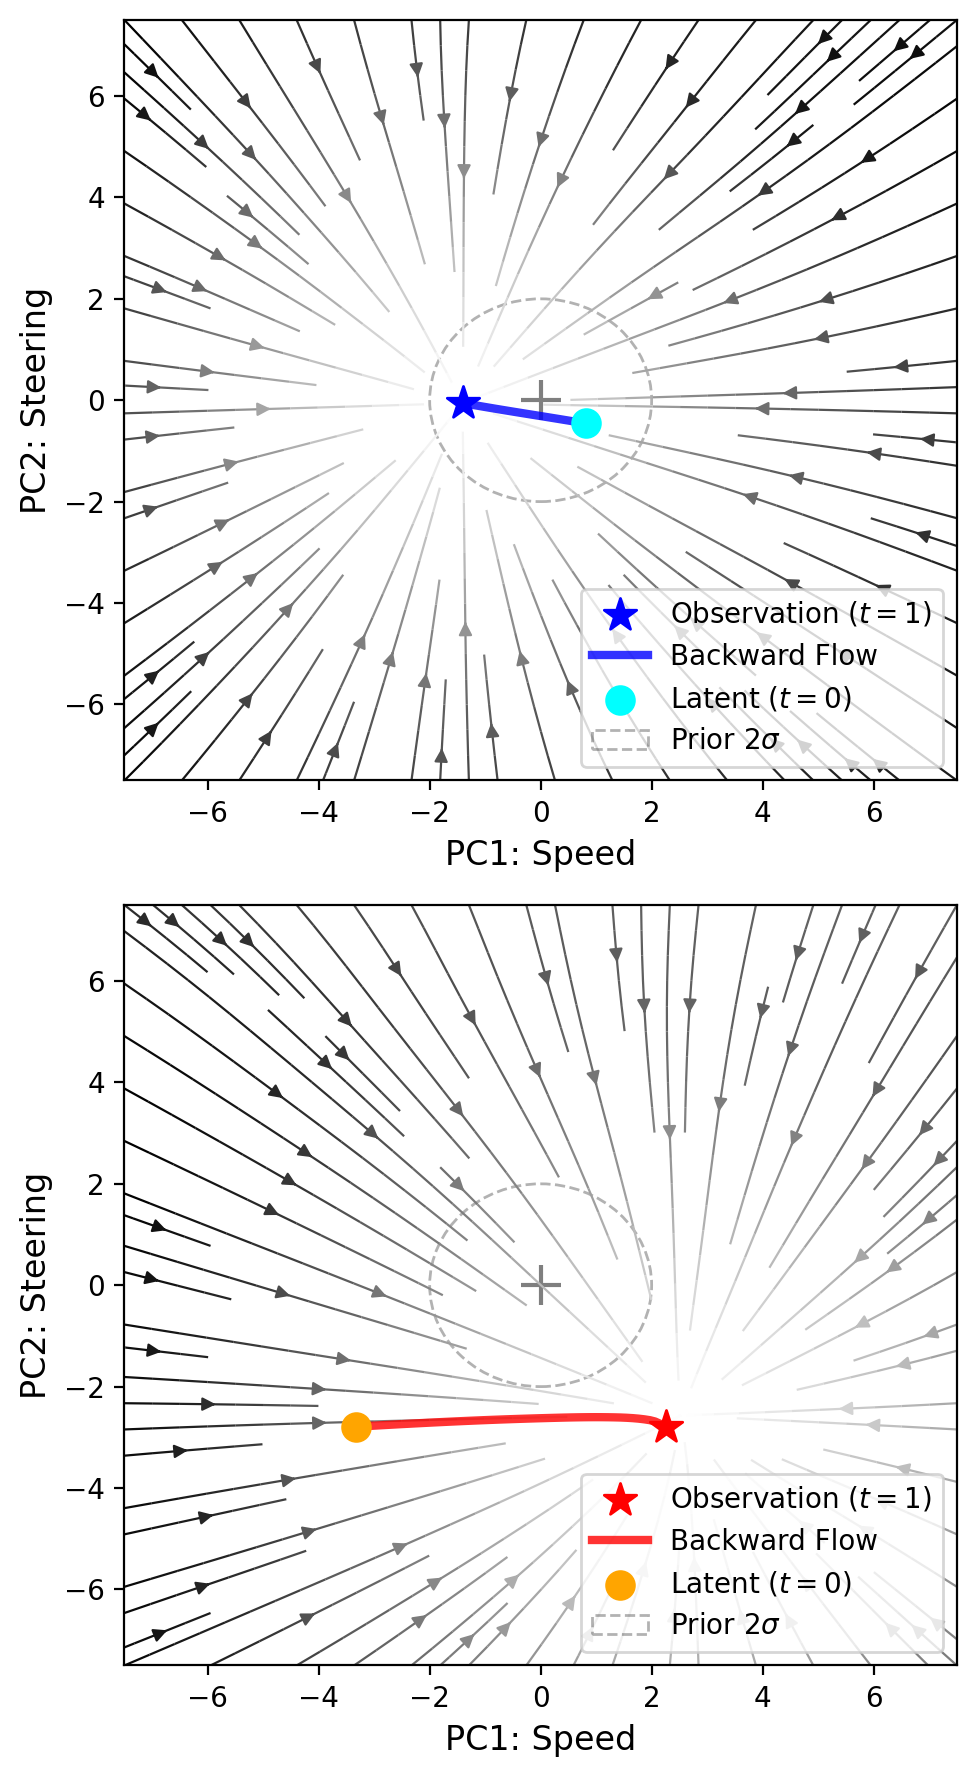

In [ ]:
# ## 4. Generate the Figure
# Side-by-side comparison of Normal vs. Anomaly integration.

# %%
# Extract Data
lim = 7.5
idx_anom = df.sort_values(by='ll', ascending=True).iloc[0]['index']

path_norm, Xn, Yn, Un, Vn, id_norm, ll_norm = get_path_and_field(idx_normal, lim)
path_anom, Xa, Ya, Ua, Va, id_anom, ll_anom = get_path_and_field(idx_anom, lim)

# Setup Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- PLOT 1: NORMAL ---
ax = axes[0]
speed_n = np.sqrt(Un**2 + Vn**2)
ax.streamplot(Xn, Yn, Un, Vn, color=speed_n, cmap='Greys', density=1.0, linewidth=0.8, arrowsize=1.0)

# Plot Path
# Start (t=1) is Data
ax.scatter(path_norm[0, 0], path_norm[0, 1], color='blue', s=150, marker='*', label='Observation ($t=1$)', zorder=5)
# Trajectory
ax.plot(path_norm[:, 0], path_norm[:, 1], color='blue', linewidth=3, alpha=0.8, label='Backward Flow')
# End (t=0) is Noise
ax.scatter(path_norm[-1, 0], path_norm[-1, 1], color='cyan', s=100, marker='o', label='Latent ($t=0$)', zorder=5)
# Gaussian Center
ax.scatter(0, 0, color='black', marker='+', s=200, alpha=0.5)
circle = plt.Circle((0, 0), 2.0, color='black', fill=False, linestyle='--', alpha=0.3, label='Prior $2\sigma$')
ax.add_patch(circle)

ax.set_title(f"A. Normal Scenario (LL: {ll_norm:.2f})\nHigh Probability Flow", fontsize=14)
ax.set_xlabel(f"PC1: Speed (Var: {pca_data['explained_variance'][0]*100:.0f}%)", fontsize=12)
ax.set_ylabel(f"PC2: Steering (Var: {pca_data['explained_variance'][1]*100:.0f}%)", fontsize=12)
ax.legend(loc='lower right')

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# --- PLOT 2: ANOMALY ---
ax = axes[1]
speed_a = np.sqrt(Ua**2 + Va**2)
ax.streamplot(Xa, Ya, Ua, Va, color=speed_a, cmap='Greys', density=1.0, linewidth=0.8, arrowsize=1.0)

# Plot Path
ax.scatter(path_anom[0, 0], path_anom[0, 1], color='red', s=150, marker='*', label='Observation ($t=1$)', zorder=5)
ax.plot(path_anom[:, 0], path_anom[:, 1], color='red', linewidth=3, alpha=0.8, label='Backward Flow')
ax.scatter(path_anom[-1, 0], path_anom[-1, 1], color='orange', s=100, marker='o', label='Latent ($t=0$)', zorder=5)
# Gaussian Center
ax.scatter(0, 0, color='black', marker='+', s=200, alpha=0.5)
circle = plt.Circle((0, 0), 2.0, color='black', fill=False, linestyle='--', alpha=0.3, label='Prior $2\sigma$')
ax.add_patch(circle)

ax.set_title(f"B. Anomalous Scenario (LL: {ll_anom:.2f})\nOut-of-Distribution Flow", fontsize=14)
ax.set_xlabel("PC1: Speed", fontsize=12)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.legend(loc='lower right')

plt.tight_layout()
# Save the figure as pdf if needed
# plt.savefig("../results/flow_normal_vs_anomaly.pdf", bbox_inches='tight')
plt.show()

## 5. Physical World Grounding
Visualizing the actual trajectories corresponding to the Latent Plots above.
*   **Left:** The Normal driving behavior (Smooth, follows lane).
*   **Right:** The Anomalous behavior (Erratic, violates geometry).

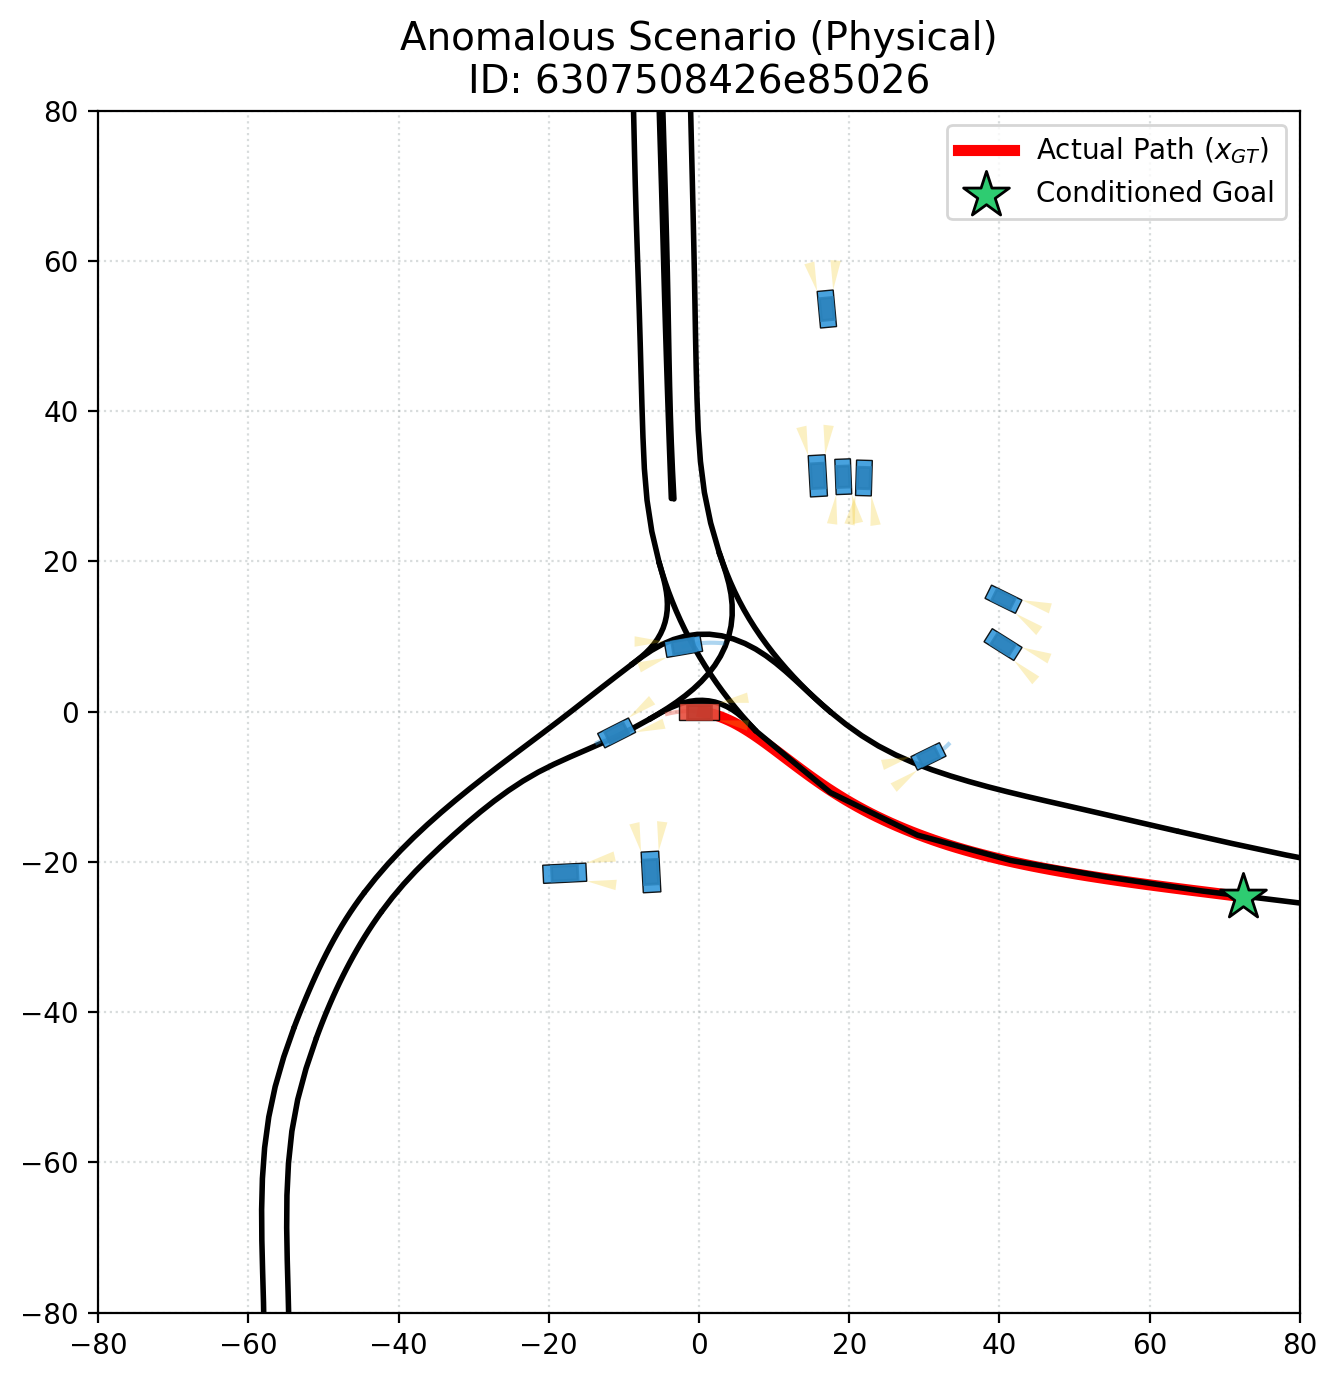

In [ ]:
# %%
from src.utils.visualization import plot_scenario

def plot_physical_comparison(id_norm, id_anom):
    # Helper to find raw file by ID (since RAM cache is unordered)
    def load_raw_by_id(target_id):
        path = next((p for p in val_set.file_list if target_id in p), None)
        if path is None: raise ValueError(f"ID {target_id} not found on disk.")
        return np.load(path)

    # Load Data
    raw_norm = load_raw_by_id(id_norm)
    raw_anom = load_raw_by_id(id_anom)
    
    # Setup Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # --- PLOT 1: NORMAL ---
    ax = axes[0]
    plot_scenario(raw_norm, ax=ax, show_future=False,)
    
    # Plot GT Future (Blue)
    gt_n = raw_norm['agents'][0, 11:91, :2]
    ax.plot(gt_n[:, 0], gt_n[:, 1], color='blue', linewidth=4, label='Actual Path ($x_{GT}$)')
    
    # Plot Goal (Green Star)
    # Note: We plot the raw final point as the goal
    goal_n = gt_n[-1]
    ax.scatter(goal_n[0], goal_n[1], color='#2ecc71', s=300, marker='*', edgecolors='black', label='Conditioned Goal', zorder=10)
    
    ax.set_title(f"Normal Scenario (Physical)\nID: {id_norm}", fontsize=14)
    ax.legend(loc='upper right')
    
    # --- PLOT 2: ANOMALY ---
    ax = axes[1]
    plot_scenario(raw_anom, ax=ax, show_future=False, lim=100)
    
    # Plot GT Future (Red)
    gt_a = raw_anom['agents'][0, 11:91, :2]
    ax.plot(gt_a[:, 0], gt_a[:, 1], color='red', linewidth=4, label='Actual Path ($x_{GT}$)')
    
    # Plot Goal
    goal_a = gt_a[-1]
    ax.scatter(goal_a[0], goal_a[1], color='#2ecc71', s=300, marker='*', edgecolors='black', label='Conditioned Goal', zorder=10)
    
    ax.set_title(f"Anomalous Scenario (Physical)\nID: {id_anom}", fontsize=14)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    # Save the figure as pdf if needed
    plt.savefig("../results/physical_comparison.pdf", bbox_inches='tight')
    plt.show()

# Execute

plot_physical_comparison(id_norm, id_anom)

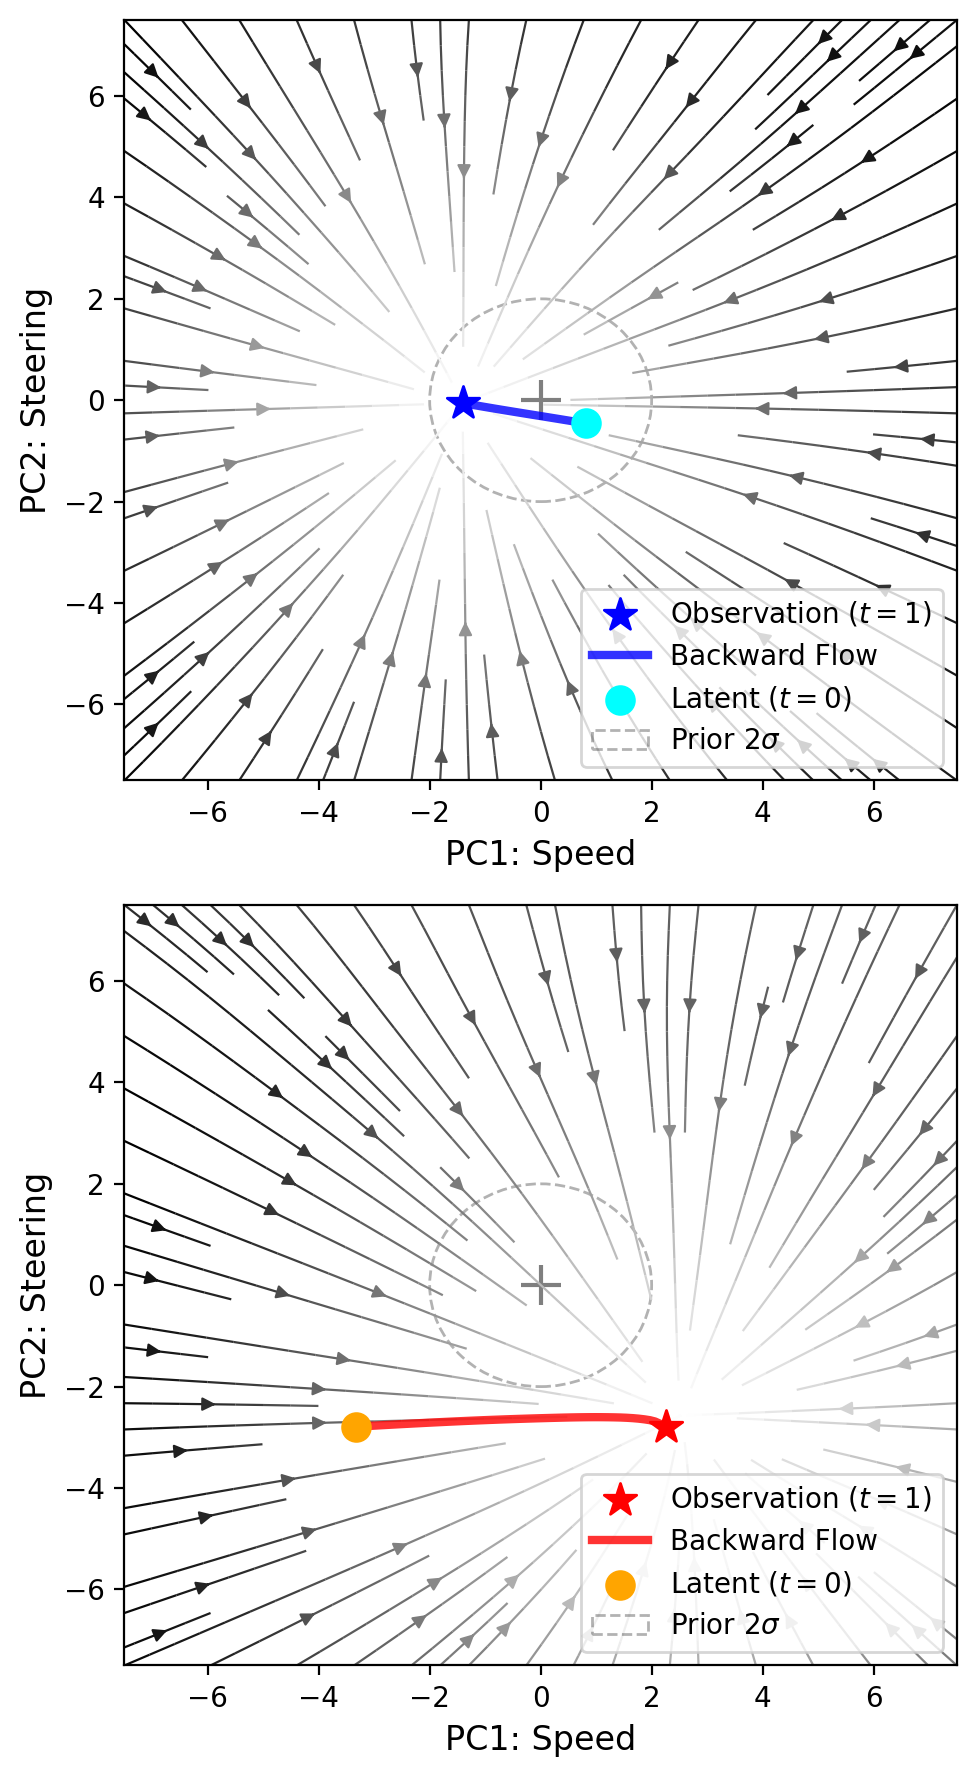

In [34]:
# ## 4. Generate the Figure
# Side-by-side comparison of Normal vs. Anomaly integration.

# %%
# Extract Data
lim = 7.5
idx_anom = df.sort_values(by='ll', ascending=True).iloc[0]['index']

path_norm, Xn, Yn, Un, Vn, id_norm, ll_norm = get_path_and_field(idx_normal, lim)
path_anom, Xa, Ya, Ua, Va, id_anom, ll_anom = get_path_and_field(idx_anom, lim)

# Setup Plot
fig, axes = plt.subplots(2, 1, figsize=(5, 9))

# --- PLOT 1: NORMAL ---
ax = axes[0]
speed_n = np.sqrt(Un**2 + Vn**2)
ax.streamplot(Xn, Yn, Un, Vn, color=speed_n, cmap='Greys', density=1.0, linewidth=0.8, arrowsize=1.0)

# Plot Path
# Start (t=1) is Data
ax.scatter(path_norm[0, 0], path_norm[0, 1], color='blue', s=150, marker='*', label='Observation ($t=1$)', zorder=5)
# Trajectory
ax.plot(path_norm[:, 0], path_norm[:, 1], color='blue', linewidth=3, alpha=0.8, label='Backward Flow')
# End (t=0) is Noise
ax.scatter(path_norm[-1, 0], path_norm[-1, 1], color='cyan', s=100, marker='o', label='Latent ($t=0$)', zorder=5)
# Gaussian Center
ax.scatter(0, 0, color='black', marker='+', s=200, alpha=0.5)
circle = plt.Circle((0, 0), 2.0, color='black', fill=False, linestyle='--', alpha=0.3, label='Prior $2\sigma$')
ax.add_patch(circle)

# ax.set_title(f"A. Normal Scenario (LL: {ll_norm:.2f})\nHigh Probability Flow", fontsize=14)
ax.set_xlabel(f"PC1: Speed", fontsize=12)
ax.set_ylabel(f"PC2: Steering", fontsize=12)
ax.legend(loc='lower right')

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

# --- PLOT 2: ANOMALY ---
ax = axes[1]
speed_a = np.sqrt(Ua**2 + Va**2)
ax.streamplot(Xa, Ya, Ua, Va, color=speed_a, cmap='Greys', density=1.0, linewidth=0.8, arrowsize=1.0)

# Plot Path
ax.scatter(path_anom[0, 0], path_anom[0, 1], color='red', s=150, marker='*', label='Observation ($t=1$)', zorder=5)
ax.plot(path_anom[:, 0], path_anom[:, 1], color='red', linewidth=3, alpha=0.8, label='Backward Flow')
ax.scatter(path_anom[-1, 0], path_anom[-1, 1], color='orange', s=100, marker='o', label='Latent ($t=0$)', zorder=5)
# Gaussian Center
ax.scatter(0, 0, color='black', marker='+', s=200, alpha=0.5)
circle = plt.Circle((0, 0), 2.0, color='black', fill=False, linestyle='--', alpha=0.3, label='Prior $2\sigma$')
ax.add_patch(circle)

# ax.set_title(f"B. Anomalous Scenario (LL: {ll_anom:.2f})\nOut-of-Distribution Flow", fontsize=14)
ax.set_xlabel("PC1: Speed", fontsize=12)
ax.set_ylabel("PC2: Steering", fontsize=12)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.legend(loc='lower right')

plt.tight_layout()
# Save the figure as pdf if needed
plt.savefig("../results/flow_normal_vs_anomaly_v2.pdf", bbox_inches='tight')
plt.show()

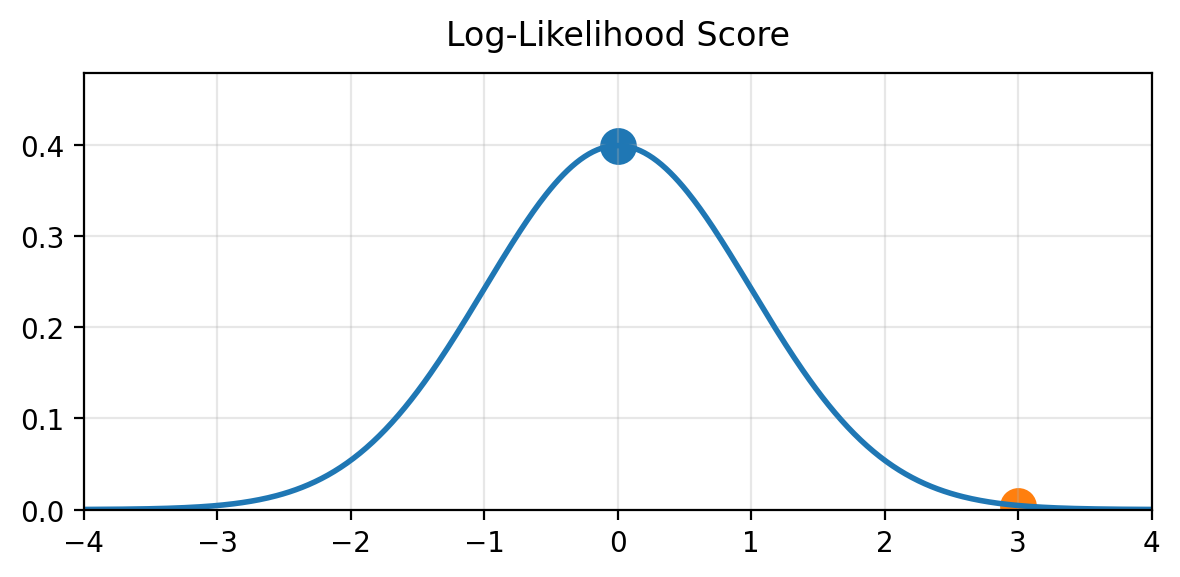

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values
x = np.linspace(-4, 4, 500)

# Gaussian function (mean=0, std=1)
mu = 0
sigma = 1
y = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Create figure
plt.figure(figsize=(6, 3))
ax = plt.gca()

# Plot Gaussian curve (thin black line)
ax.plot(x, y, linewidth=2)

# ---- Points ----
# Peak (safe / expert)
x_safe = 0
y_safe = (1 / (np.sqrt(2 * np.pi) * sigma))

# Tail (unsafe / anomalous)
x_unsafe = 3
y_unsafe = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (x_unsafe ** 2))

# Plot points
ax.scatter(x_safe, y_safe, s=150)
ax.scatter(x_unsafe, y_unsafe, s=150)

# ---- Style cleanup ----
ax.set_xlim(-4, 4)
ax.set_ylim(0, max(y) * 1.2)

# Remove ticks and spines for clean academic look
# ax.set_xticks([])
# ax.set_yticks([])

# for spine in ax.spines.values():
#     spine.set_visible(False)

# Add label below
plt.title("Log-Likelihood Score", fontsize=12, pad=10)

# White background
ax.set_facecolor("white")
plt.gcf().patch.set_facecolor("white")
plt.grid(True, alpha=0.3)

plt.tight_layout()

# save the plot as pdf
plt.savefig("../results/likelihood_score_represenation.pdf", bbox_inches='tight')

plt.show()
